In [1]:
from torchvision import datasets

from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt 

import numpy as np
import pickle

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.ticker as ticker
import locale

locale.setlocale(locale.LC_ALL, 'de_DE')

plt.rcParams["font.family"] = 'Djvu Serif'

plt.rcParams['text.usetex'] = True

plt.rcParams['text.latex.unicode'] = True

plt.rcParams['text.latex.preamble'] = [r'\usepackage[utf8x]{inputenc}', 
                                       r'\usepackage[english,russian]{babel}', 
                                       r'\usepackage{amsmath}']

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

plt.rcParams['axes.formatter.use_locale'] = True

In [3]:
from src.fashion_mnist import (train_student_without_teacher, 
                               train_teacher, 
                               train_student_with_teacher, 
                               Student, 
                               Teacher)

# Загрузка датасета

In [4]:
MNIST = datasets.FashionMNIST('../data/', train=True, download=False, transform=None)
train_data_cnn = TensorDataset(MNIST.data.view(-1, 1, 28, 28).float() / 255, MNIST.targets)
train_data = TensorDataset(MNIST.data.view(-1, 28 * 28).float() / 255, MNIST.targets)

MNIST = datasets.FashionMNIST('../data/', train=False, download=False, transform=None)
test_data_cnn = TensorDataset(MNIST.data.view(-1, 1, 28, 28).float() / 255, MNIST.targets)
test_data = TensorDataset(MNIST.data.view(-1, 28 * 28).float() / 255, MNIST.targets)

# Модель без учителя

In [5]:
DICT = train_student_without_teacher(train_data, test_data)


In [6]:
# with open('../dumps/fashion_mnist/train_student_without_teacher.pkl', 'wb') as f:
#     pickle.dump(DICT, f)

In [7]:
# with open('../dumps/fashion_mnist/train_student_without_teacher.pkl', 'rb') as f:
#     DICT = pickle.load(f)

In [8]:
list_of_student_models = DICT['list_of_student_models']
list_of_losses_train = DICT['list_of_losses_train']
list_of_losses_test = DICT['list_of_losses_test']
list_of_acc_train = DICT['list_of_acc_train']
list_of_acc_test = DICT['list_of_acc_test']

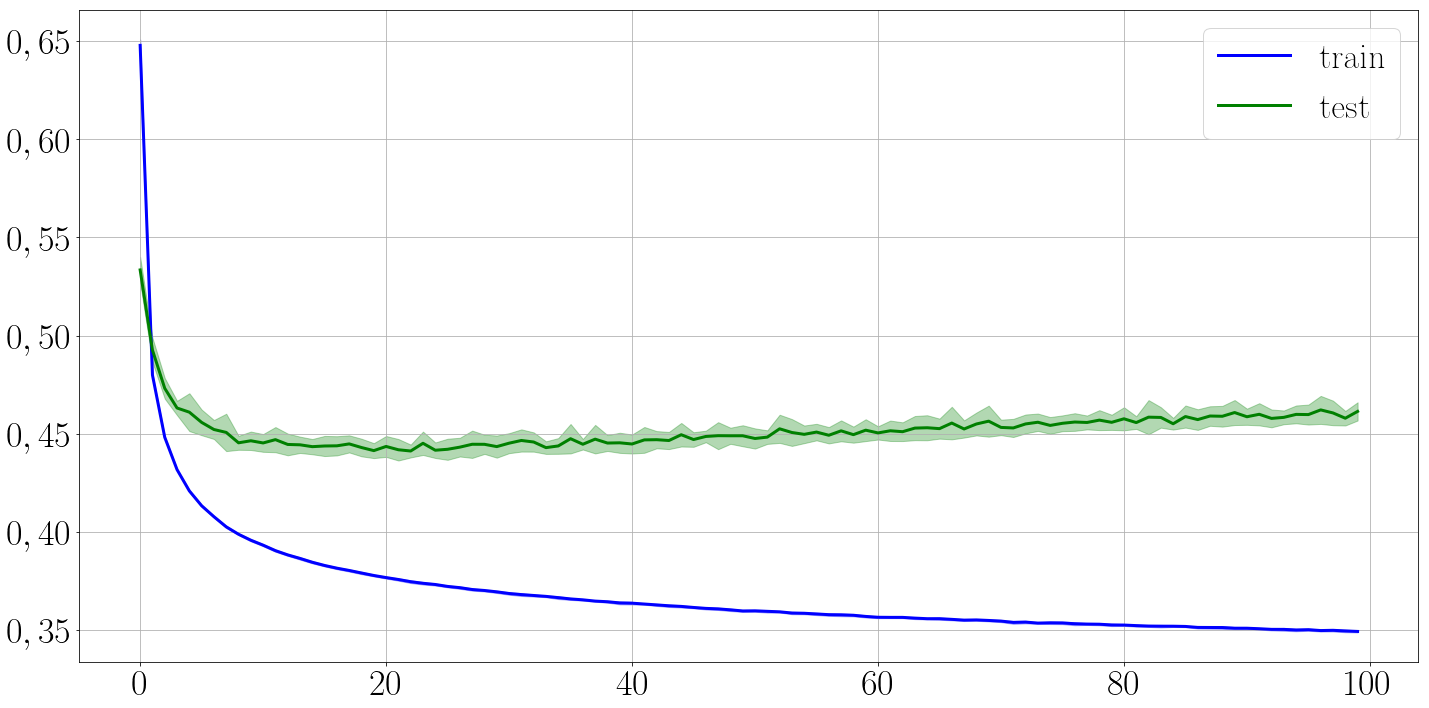

In [9]:
mean = np.array(list_of_losses_train).mean(0)
std = np.array(list_of_losses_train).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'blue', label = 'train')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')


mean = np.array(list_of_losses_test).mean(0)
std = np.array(list_of_losses_test).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'green', label = 'test')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

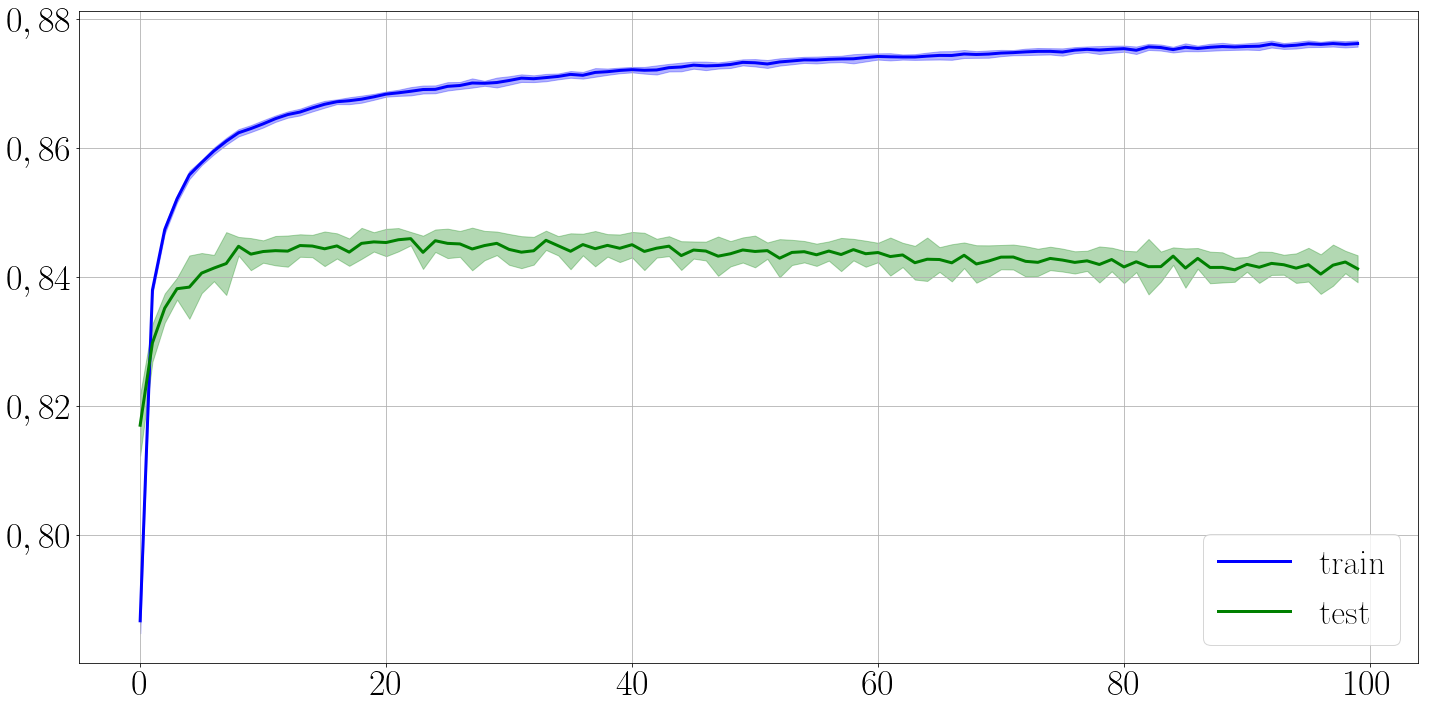

In [10]:
mean = np.array(list_of_acc_train).mean(0)
std = np.array(list_of_acc_train).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'blue', label = 'train')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')


mean = np.array(list_of_acc_test).mean(0)
std = np.array(list_of_acc_test).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'green', label = 'test')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

# Модель с учителем

In [11]:
teacher = train_teacher(train_data_cnn, test_data_cnn)['model']

In [12]:
# with open('../dumps/fashion_mnist/teacher.pkl', 'wb') as f:
#     pickle.dump(teacher, f)

In [13]:
# with open('../dumps/fashion_mnist/teacher.pkl', 'rb') as f:
#     teacher = pickle.load(f)

In [14]:
DICT = train_student_with_teacher(teacher, train_data, test_data, train_data_cnn, test_data_cnn, epochs=100, meaning=5, T=2,lamb=0.25)


In [15]:
# with open('../dumps/fashion_mnist/train_student_with_teacher.pkl', 'wb') as f:
#     pickle.dump(DICT, f)

In [16]:
# with open('../dumps/fashion_mnist/train_student_with_teacher.pkl', 'rb') as f:
#     DICT = pickle.load(f)

In [17]:
list_of_student_models_dist = DICT['list_of_student_models_dist']
list_of_losses_train_dist = DICT['list_of_losses_train_dist']
list_of_losses_test_dist = DICT['list_of_losses_test_dist']
list_of_acc_train_dist = DICT['list_of_acc_train_dist']
list_of_acc_test_dist = DICT['list_of_acc_test_dist']

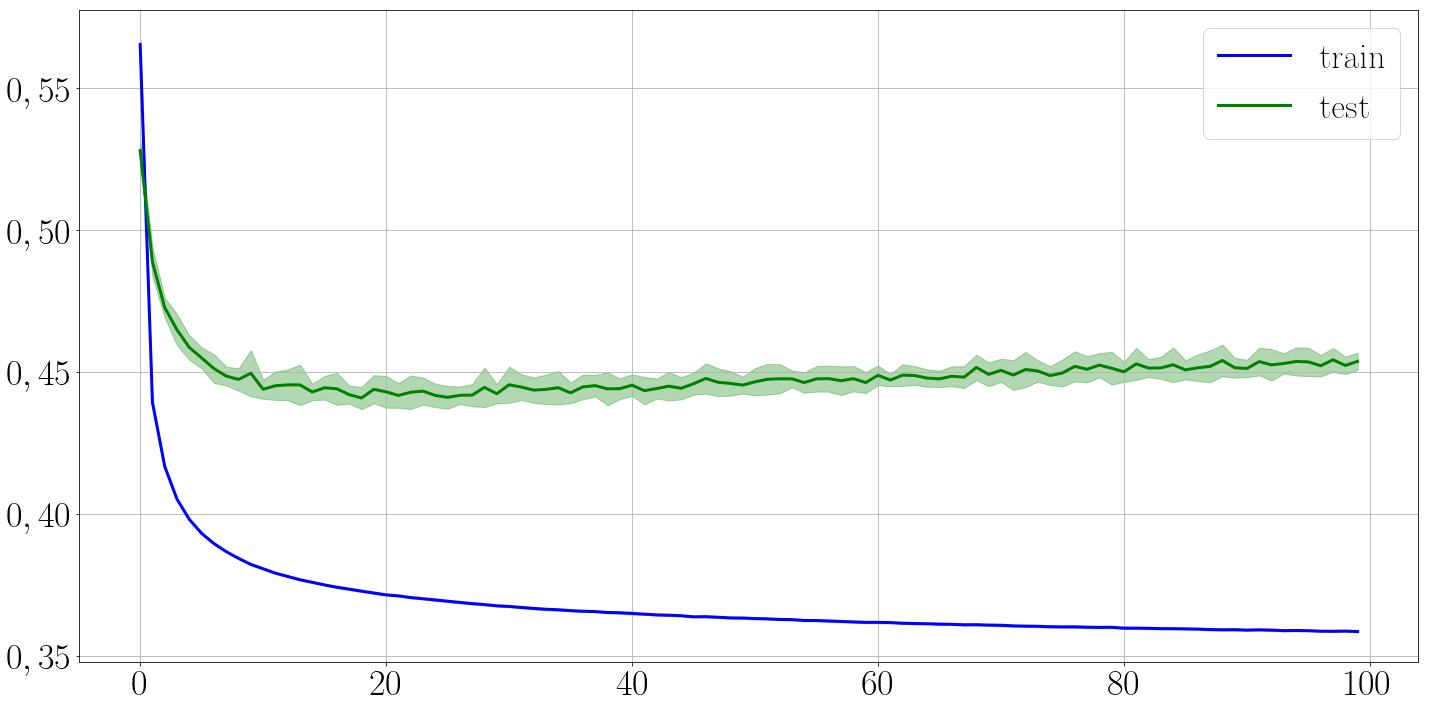

In [18]:
mean = np.array(list_of_losses_train_dist).mean(0)
std = np.array(list_of_losses_train_dist).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'blue', label = 'train')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')


mean = np.array(list_of_losses_test_dist).mean(0)
std = np.array(list_of_losses_test_dist).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'green', label = 'test')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

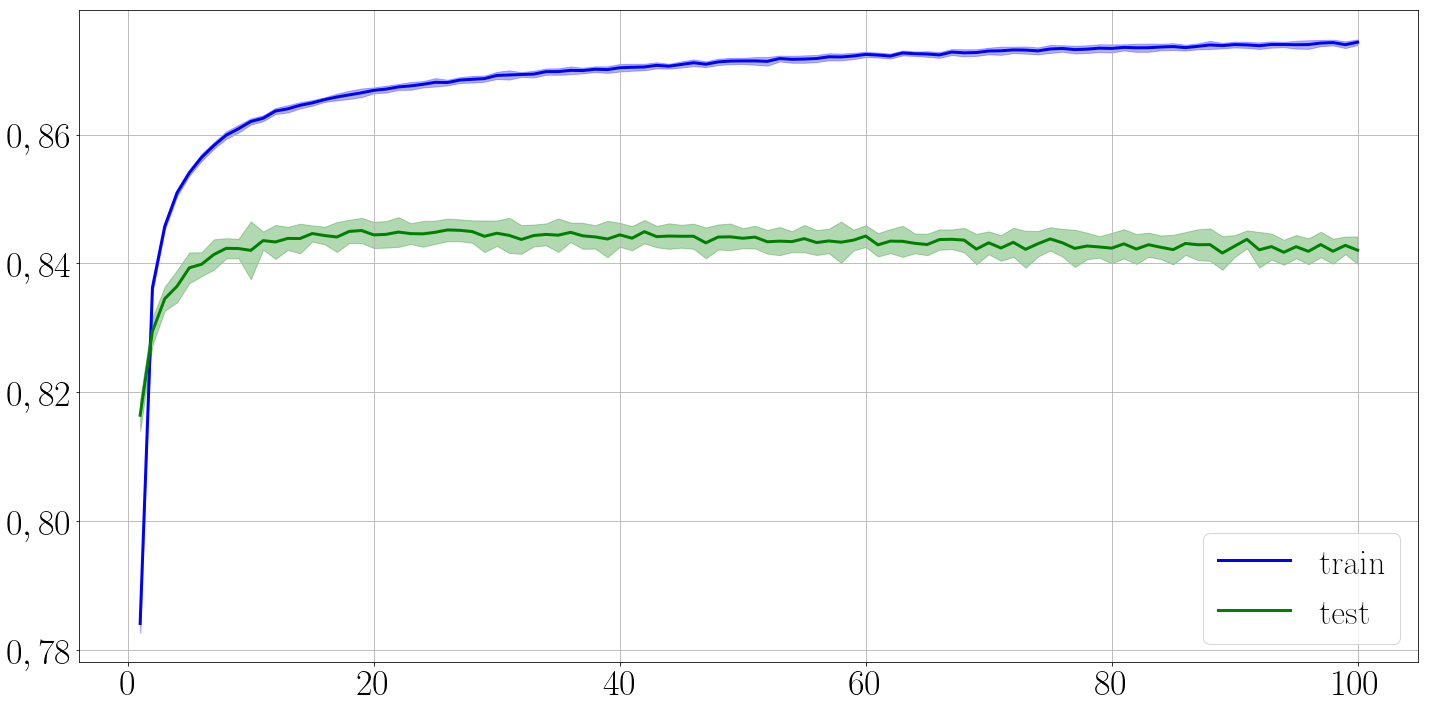

In [19]:
mean = np.array(list_of_acc_train_dist).mean(0)
std = np.array(list_of_acc_train_dist).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'blue', label = 'train')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')


mean = np.array(list_of_acc_test_dist).mean(0)
std = np.array(list_of_acc_test_dist).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'green', label = 'test')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

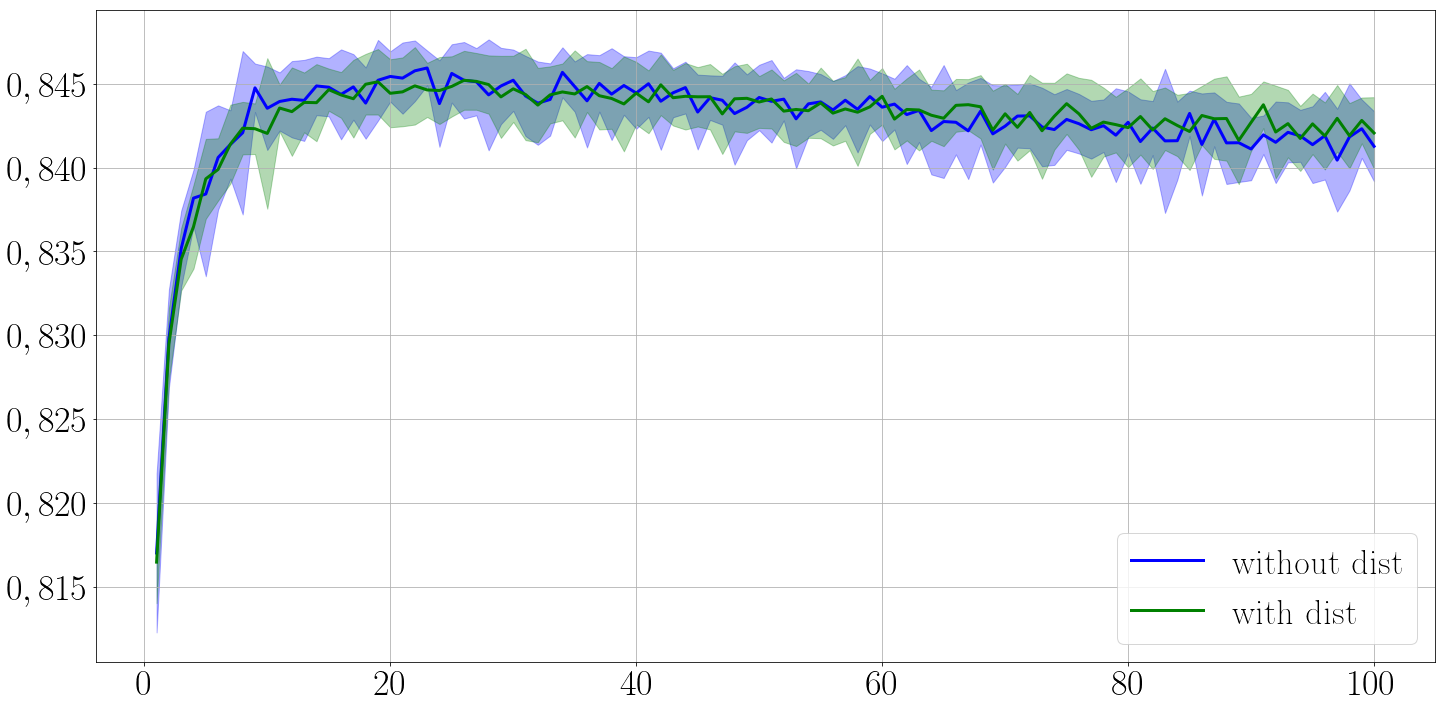

In [20]:
mean = np.array(list_of_acc_test).mean(0)
std = np.array(list_of_acc_test).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'blue', label = 'without dist')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')



mean = np.array(list_of_acc_test_dist).mean(0)
std = np.array(list_of_acc_test_dist).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'green', label = 'with dist')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

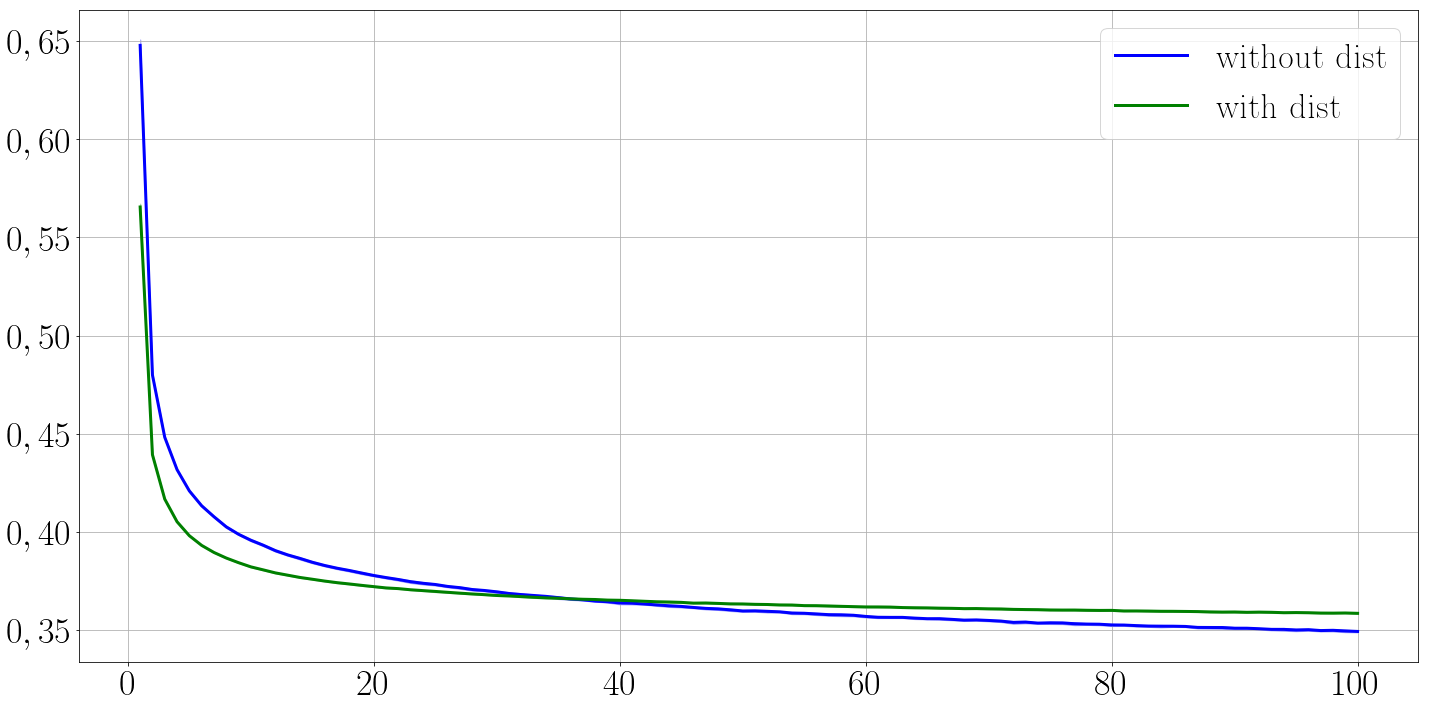

In [21]:
mean = np.array(list_of_losses_train).mean(0)
std = np.array(list_of_losses_train).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'blue', label = 'without dist')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')



mean = np.array(list_of_losses_train_dist).mean(0)
std = np.array(list_of_losses_train_dist).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'green', label = 'with dist')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

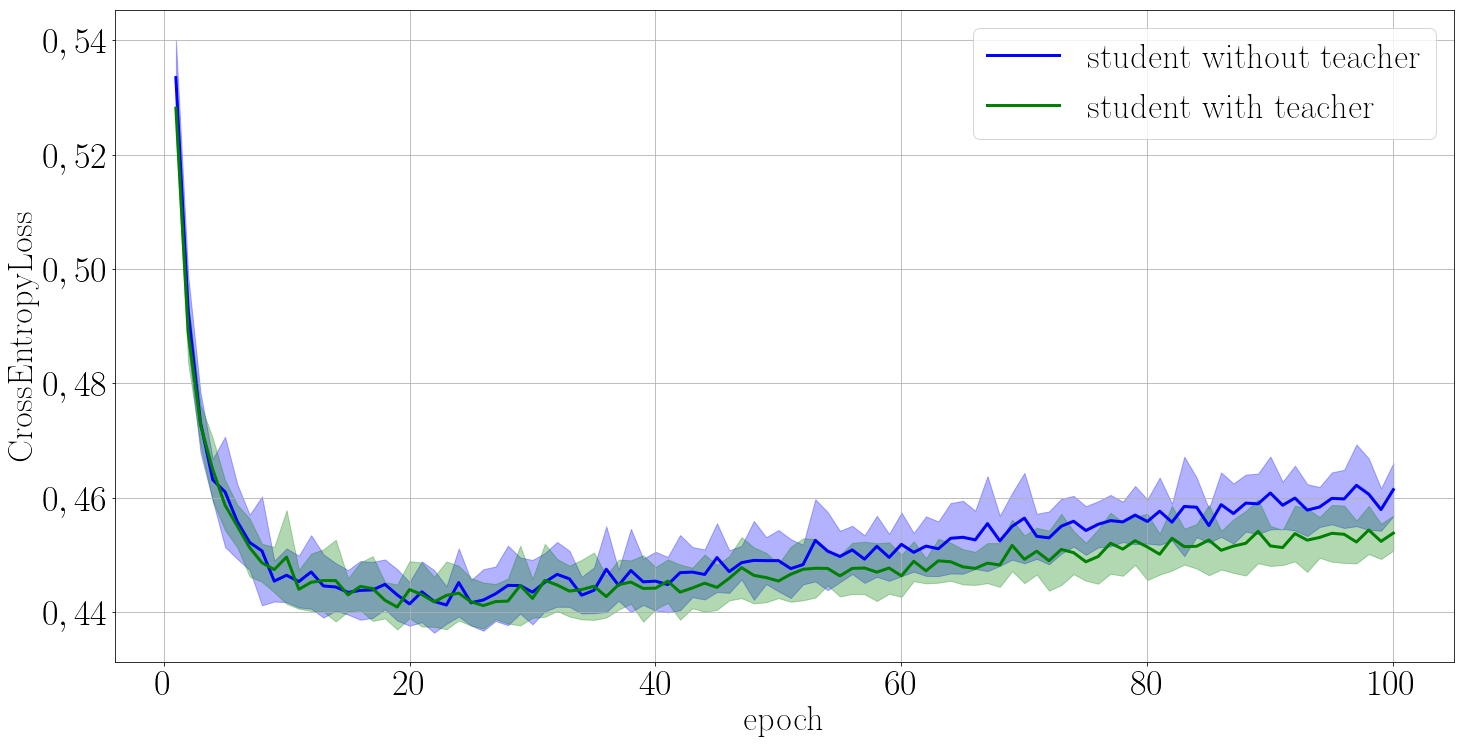

In [22]:
mean = np.array(list_of_losses_test).mean(0)
std = np.array(list_of_losses_test).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'blue', label = 'student without teacher')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')



mean = np.array(list_of_losses_test_dist).mean(0)
std = np.array(list_of_losses_test_dist).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'green', label = 'student with teacher')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')

plt.xlabel('epoch')
plt.ylabel('CrossEntropyLoss')

plt.grid()
plt.legend(loc='best')
plt.show()

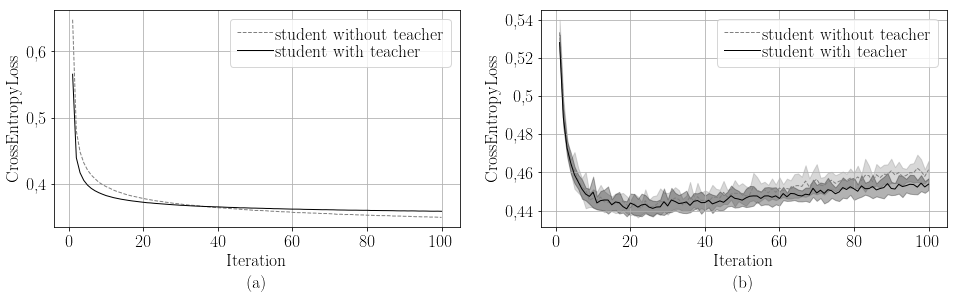

In [23]:
Text_size = 18

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (16, 4)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
####################################################

fig = plt.figure()

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.3n}'))
    ax[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2n}'))
    
# Train part
mean = np.array(list_of_losses_train).mean(0)
std = np.array(list_of_losses_train).std(0)
x_axis = np.arange(1, len(mean)+1)

ax[0].plot(x_axis, mean, '--',color = 'gray', label = 'student without teacher')
# ax[0].fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')


mean = np.array(list_of_losses_train_dist).mean(0)
std = np.array(list_of_losses_train_dist).std(0)
x_axis = np.arange(1, len(mean)+1)

ax[0].plot(x_axis, mean, color = 'black', label = 'student with teacher')
# ax[0].fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


ax[0].set_title('(a)', y=-0.3)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('CrossEntropyLoss')

ax[0].grid()
ax[0].legend(loc='best')

# Test part
mean = np.array(list_of_losses_test).mean(0)
std = np.array(list_of_losses_test).std(0)
x_axis = np.arange(1, len(mean)+1)

ax[1].plot(x_axis, mean, '--', color = 'gray', label = 'student without teacher')
ax[1].fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'gray')

mean = np.array(list_of_losses_test_dist).mean(0)
std = np.array(list_of_losses_test_dist).std(0)
x_axis = np.arange(1, len(mean)+1)

ax[1].plot(x_axis, mean, color = 'black', label = 'student with teacher')
ax[1].fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'black')

ax[1].set_title('(b)', y=-0.3)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('CrossEntropyLoss')

ax[1].grid()
ax[1].legend(loc='best')


plt.show()